In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

torch.manual_seed(123)
np.random.seed(123)

print('torch version:', torch.__version__)

torch version: 2.6.0+cpu


In [16]:
# 创建数据集
SampleSize = 1500   # 总样本数
SampleDim = 5      # 向量维度
X = np.random.randn(SampleSize, SampleDim).astype('float32')
y = X.argmax(axis=1).astype('int64')  # 标签是最大值所在索引

# 划分训练集和验证集
perm = np.random.permutation(SampleSize)  # 随机打乱顺序
train_idx = perm[:1200]
val_idx = perm[1200:]
X_train, y_train = X[train_idx], y[train_idx]
X_val, y_val = X[val_idx], y[val_idx]

print('训练集形状:', X_train.shape, '验证集形状:', X_val.shape)


训练集形状: (1200, 5) 验证集形状: (300, 5)


In [17]:
batch_size = 64
# 转换为pytorch张量，同时将特征向量与标签向量绑定
train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
val_ds = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
# 使用数据加载器打乱、组织、分批处理数据
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=128, shuffle=False)

In [18]:
# 定义线性层nn.Linear(5,5)
class SimpleLinearClassifier(nn.Module):
    def __init__(self, input_dim=5, num_classes=5):
        super().__init__()
        self.fc = nn.Linear(input_dim, num_classes)  # 是对输入数据x执行线性变换：
    def forward(self, x):
        return self.fc(x)

model = SimpleLinearClassifier(SampleDim, SampleDim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.5)

print(model)


SimpleLinearClassifier(
  (fc): Linear(in_features=5, out_features=5, bias=True)
)


In [19]:
num_epochs = 120
train_losses = []
val_losses = []
val_accs = []

for epoch in range(1, num_epochs+1):
    # 训练
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()  # 每次反向传播前把上一次的梯度清空
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()  # 反向传播，自动算出每个参数的梯度
        optimizer.step()  # 更新参数
        running_loss += loss.item() * xb.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # 验证
    model.eval()
    running_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            logits = model(xb)
            loss = criterion(logits, yb)
            running_val_loss += loss.item() * xb.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
    val_loss = running_val_loss / len(val_loader.dataset)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    if epoch % 20 == 0 or epoch == 1:
        print(f"epoch: {epoch:3d} | train loss: {train_loss:.4f} | val loss: {val_loss:.4f} | val accuracy: {val_acc:.4f}")


epoch:   1 | train loss: 1.1065 | val loss: 0.6542 | val accuracy: 0.9200
epoch:  20 | train loss: 0.2070 | val loss: 0.1924 | val accuracy: 0.9800
epoch:  40 | train loss: 0.1616 | val loss: 0.1500 | val accuracy: 0.9867
epoch:  60 | train loss: 0.1403 | val loss: 0.1302 | val accuracy: 0.9867
epoch:  80 | train loss: 0.1269 | val loss: 0.1180 | val accuracy: 0.9867
epoch: 100 | train loss: 0.1176 | val loss: 0.1093 | val accuracy: 0.9867
epoch: 120 | train loss: 0.1106 | val loss: 0.1022 | val accuracy: 0.9867


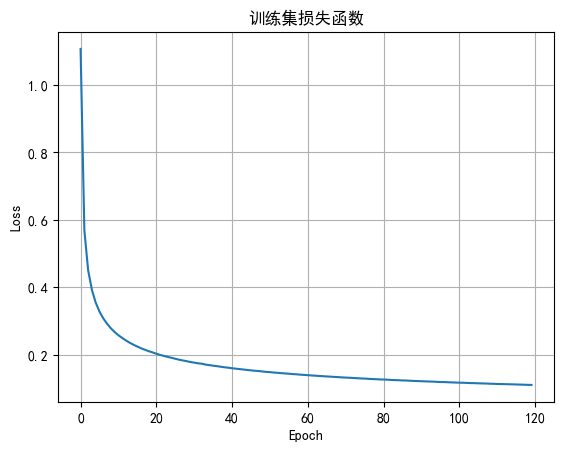

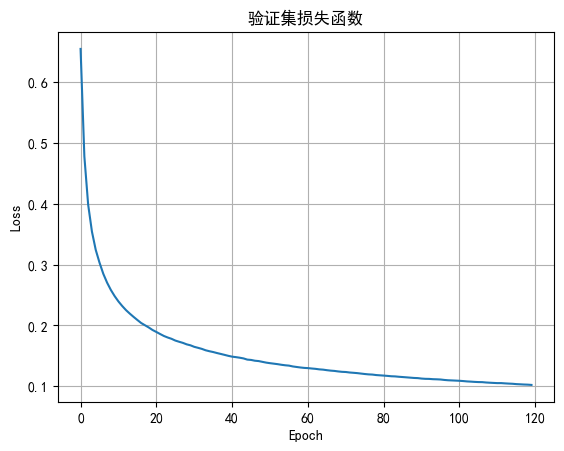

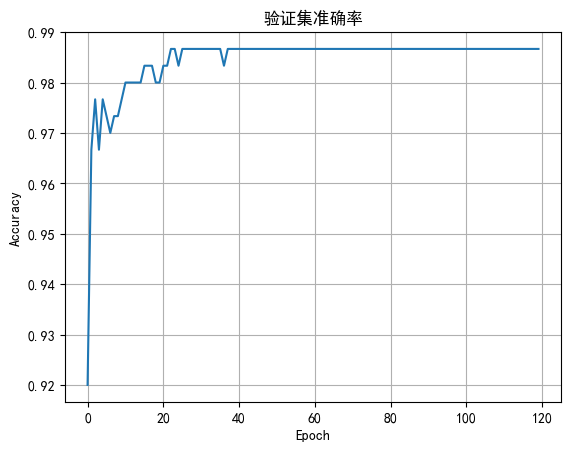

In [20]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 训练损失
plt.figure()
plt.plot(train_losses)
plt.title('训练集损失函数')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# 验证损失
plt.figure()
plt.plot(val_losses)
plt.title('验证集损失函数')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# 验证准确率
plt.figure()
plt.plot(val_accs)
plt.title('验证集准确率')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

In [25]:
model.eval()
with torch.no_grad():
    sample_x = torch.from_numpy(X_val[:12])  # 验证前12个样本
    logits = model(sample_x)
    preds = logits.argmax(dim=1).numpy()
sample_table = np.column_stack([np.round(X_val[:12],3), y_val[:12], preds])
df_samples = pd.DataFrame(sample_table, columns=[f'x{i}' for i in range(SampleDim)]+['label','pred'])
print(df_samples)


       x0     x1     x2     x3     x4  label  pred
0  -1.772  0.585 -0.895 -0.875 -0.129    1.0   1.0
1   1.309  0.881  0.887 -0.732  1.257    0.0   0.0
2   0.038 -0.948  1.613  0.381 -0.251    2.0   2.0
3   0.020 -0.194  0.134  0.704  0.666    3.0   3.0
4  -0.731 -0.689  1.432  0.466 -0.519    2.0   2.0
5  -2.640 -0.200 -0.323  1.526 -1.428    3.0   3.0
6  -0.455 -0.796 -0.797 -0.532  2.214    4.0   4.0
7  -0.740  0.268  0.055 -0.917  1.676    4.0   4.0
8  -0.039  1.449 -1.870 -0.599  0.983    1.0   1.0
9  -0.121  0.753 -0.043 -0.844 -0.960    1.0   1.0
10 -0.145  1.869 -0.519 -0.062 -0.103    1.0   1.0
11  1.383  0.285 -1.075  0.661 -0.655    0.0   0.0
